## Testing the different models

- Naive Forecast (done)
- SARIMA (done)
- LSTM (in progress)
- XGBoost (to implement)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
from river_forecast.training_data_access import get_combined_flow_split

In [3]:
train, validation, test = get_combined_flow_split()

Text(0, 0.5, 'Flow')

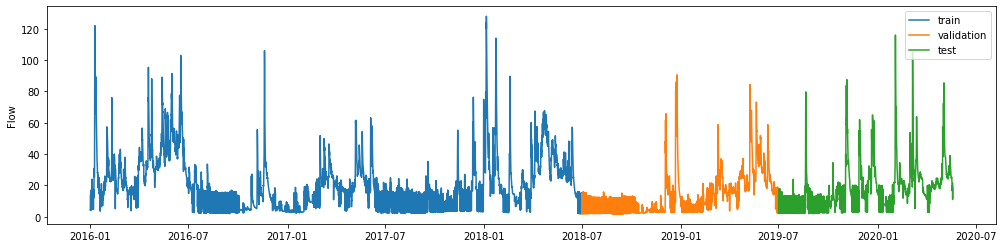

In [4]:
fig, ax = plt.subplots(figsize=(17, 4))
ax.plot(train, label='train')
ax.plot(validation, label='validation')
ax.plot(test, label='test')
ax.legend()
ax.set_ylabel('Flow')

In [5]:
from river_forecast.forecast import SARIMAXForecast, NaiveForecast, LSTMForecast, LSTMSeq2SeqForecast

In [6]:
nf = NaiveForecast()
sf = SARIMAXForecast()
lstm = LSTMForecast()
lstm2 = LSTMSeq2SeqForecast()

In [7]:
lstm2.dynamic_forecast(test.iloc[0:1])

2019-07-01 02:00:00    11.314008
2019-07-01 03:00:00     5.204216
2019-07-01 04:00:00     4.890938
2019-07-01 05:00:00     5.072639
2019-07-01 06:00:00     5.368979
2019-07-01 07:00:00     5.618685
Freq: H, dtype: float32

In [11]:
input_length = 72
forecast_length = int(6)
n_possible_forecasts = len(validation) - input_length + 1 - forecast_length
n_forecasts = 500 # Max: n_possible_forecasts


In [ ]:
forecasts = np.zeros((4, n_forecasts, forecast_length))
real_values = np.zeros((n_forecasts, forecast_length))
np.random.seed(5)
for i, j in enumerate(np.random.choice(n_possible_forecasts, size=n_forecasts, replace=False)):
    #if i%100 == 0:
    print(i)
    recent_flow = validation.iloc[j:(j + input_length)]
    real_values[i, :] = validation.iloc[(j + input_length):(j + input_length + forecast_length)]['discharge']
    forecasts[3, i, :] = lstm2.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[2, i, :] = lstm.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[1, i, :] = sf.dynamic_forecast(recent_flow, n_hours=forecast_length)
    forecasts[0, i, :] = nf.dynamic_forecast(recent_flow, n_hours=forecast_length)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86


In [18]:
maes = np.mean(np.abs(forecasts - real_values[np.newaxis, ...]), axis=1)

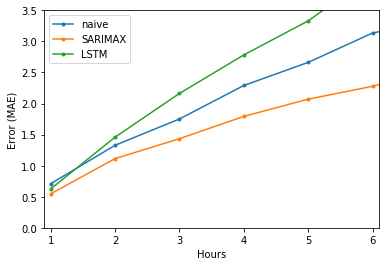

In [36]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes[1], marker='.', label='SARIMAX')
ax.plot(np.arange(forecast_length) + 1, maes[2], marker='.', label='LSTM')
ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
ax.set_xlim([0.9, 6.1])
ax.set_ylim([0, 3.5])
ax.legend()

In [22]:
rmses = np.sqrt(np.mean((forecasts - real_values[np.newaxis, ...])**2, axis=1))

(0, 10)

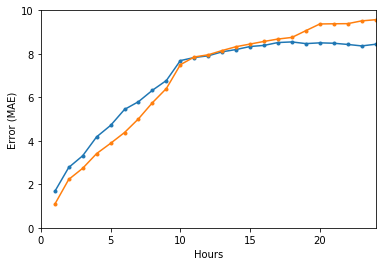

In [23]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, rmses[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, rmses[1], marker='.', label='SARIMAX')
ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
ax.set_xlim([0, 24])
ax.set_ylim([0, 10])

In [107]:
maes_diff = np.mean(np.abs(np.diff(forecasts, axis=1) - np.diff(real_values[np.newaxis, ...], axis=1)), axis=1)

(0, 1.4)

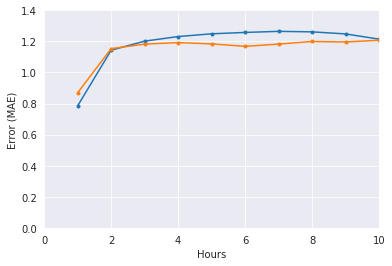

In [112]:
fig, ax = plt.subplots()
ax.plot(np.arange(forecast_length) + 1, maes_diff[0], marker='.', label='naive')
ax.plot(np.arange(forecast_length) + 1, maes_diff[1], marker='.', label='SARIMAX')
ax.set_ylabel('Error (MAE)')
ax.set_xlabel('Hours')
ax.set_xlim([0, 10])
ax.set_ylim([0, 1.4])

In [104]:
forecasts.shape

(2, 8616, 72)

In [17]:
np.random.choice(10, size=1, replace=False)

array([5])

In [35]:
recent_flow = recent_flow.diff(periods=1).dropna()['discharge']

In [37]:
recent_flow.iloc[-1]

-0.30000000000000426

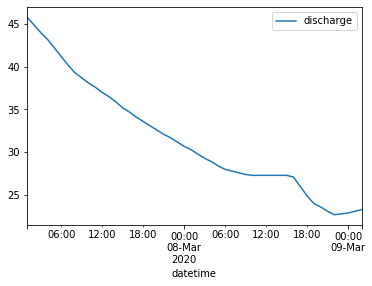

In [34]:
test.iloc[6000:6050].plot()